In [14]:
import os
from matplotlib import pyplot
import numpy as np
import torch
from scipy.spatial.transform import Rotation
import pickle
from PIL import Image
from IPython.display import display
from ipywidgets import interact
from importlib import reload
import functools
import tqdm
import cv2

In [15]:
import pyrender

In [16]:
import face3drotationaugmentation.dataset300wlp as dataset300wlp
import face3drotationaugmentation.vis as vis
import face3drotationaugmentation.graphics as graphics
import face3drotationaugmentation.sampling as sampling
from face3drotationaugmentation.graphics import get_hpb, make_rot
from face3drotationaugmentation import depthestimation

In [17]:
depthestimation.init()

Using cache found in /home/mwelter/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/mwelter/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/mwelter/.cache/torch/hub/intel-isl_MiDaS_master


In [18]:
deg2rad = np.pi/180.

In [19]:
ds300wlp = dataset300wlp.Dataset300WLP(os.path.join(os.environ['DATADIR'],'300W-LP.zip'))

In [20]:
%matplotlib inline

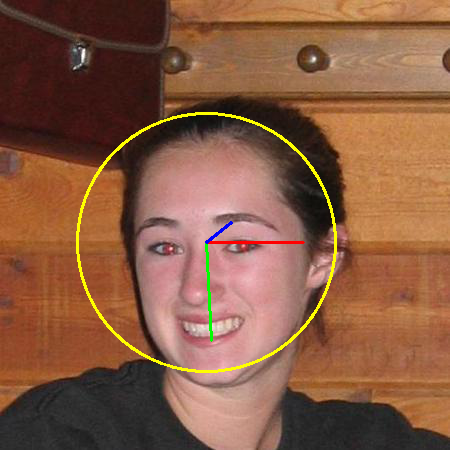

In [21]:
sample = ds300wlp[17] # 19, 6, -3
img = sample['image'].copy()
vis.draw_pose(img, sample, 255, 2)
display(Image.fromarray(img))

In [22]:
reload(graphics)

<module 'face3drotationaugmentation.graphics' from '/mnt/SSDNTFS/Programmierung/head-tracking/face-3d-rotation-augmentation/face3drotationaugmentation/graphics.py'>

In [23]:
def launch_pyrender_viewer(sample):
    shapeparam = sample['shapeparam']
    image = sample['image']
    h, w, _ = image.shape
    augscene = graphics.FaceAugmentationScene(sample)
    with augscene(Rotation.identity(), shapeparam) as items:
        scene, _, _ = items
        pyrender.Viewer(scene, viewport_size=(w,h))

launch_pyrender_viewer(sample)

In [24]:
def infer_nice_depth_estimate_from_image(sample):
    depth_estimate = depthestimation.inference(sample['image'])
    sigma = sample['scale']*0.02
    ks = int(sigma*3) | 1
    blurred_depth = cv2.GaussianBlur(depth_estimate,(ks,ks),sigma)
    return blurred_depth, depth_estimate

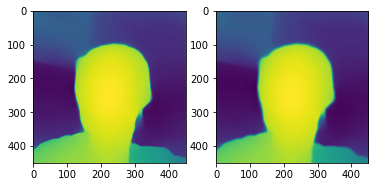

In [25]:
blurred_depth, depth_estimate = infer_nice_depth_estimate_from_image(sample)
fig, (ax1,ax2) = pyplot.subplots(1,2)
ax1.imshow(depth_estimate)
ax2.imshow(blurred_depth)

In [35]:
reload(graphics)

<module 'face3drotationaugmentation.graphics' from '/mnt/SSDNTFS/Programmierung/head-tracking/face-3d-rotation-augmentation/face3drotationaugmentation/graphics.py'>

In [36]:
def launch_pyrender_viewer(sample):
    shapeparam = sample['shapeparam']
    image = sample['image']
    h, w, _ = image.shape
    augscene = graphics.FaceAugmentationScene(sample)
    curve1, curve2 = augscene.face_model.set_non_face_by_depth_estimate(blurred_depth)
    if 0:
        i = np.arange(68)
        pyplot.plot(i, curve1, i, curve2)
        pyplot.show()
    with augscene(Rotation.identity(), shapeparam) as items:
        scene, _, _ = items
        pyrender.Viewer(scene, viewport_size=(w,h))

launch_pyrender_viewer(sample)

In [37]:
augscene = graphics.FaceAugmentationScene(sample)
_, _ = augscene.face_model.set_non_face_by_depth_estimate(depth_estimate)
h, w, _ = sample['image'].shape
renderer = pyrender.OffscreenRenderer(viewport_width=w, viewport_height=h)

print (f"hpb = {get_hpb(sample['rot'])/deg2rad}")

@interact(yaw = (-np.pi*0.5, np.pi*0.5), pitch=(-np.pi*0.25,np.pi*0.25), roll=(-np.pi*0.1,np.pi*0.1))
def showit(yaw, pitch, roll):
    rotoffset = make_rot([yaw,pitch,roll])
    shapeparam = sample['shapeparam']

    with augscene(rotoffset, shapeparam) as items:
        scene, (R,t), keypoints = items
        color, _ = renderer.render(scene)
        color = np.ascontiguousarray(color)

    roi = dataset300wlp.head_bbox_from_keypoints(keypoints)

    #print(graphics.get_hpb(R), t)

    vis.draw_pose(color, {
        'rot' : R,
        'xy' : t,
        'scale' : sample['scale'],
        'pt3d_68' : keypoints,
        'roi' : roi
    }, 255, 2)
    display(Image.fromarray(np.hstack([sample['image'],color])))

hpb = [14.63913813 11.65275391 -0.27761595]


interactive(children=(FloatSlider(value=0.0, description='yaw', max=1.5707963267948966, min=-1.570796326794896…

In [17]:
reload(sampling)

<module 'face3drotationaugmentation.sampling' from '/mnt/SSDNTFS/Programmierung/head-tracking/face-3d-rotation-augmentation/face3drotationaugmentation/sampling.py'>

In [21]:
sample = ds300wlp[19]
shapetransfer_sample = ds300wlp[21]

rng = np.random.RandomState(12345)

more_rots = sampling.sample_more_face_params(sample['rot'], rng)

blurred_depth, _ = infer_nice_depth_estimate_from_image(sample)

augscene = graphics.FaceAugmentationScene(sample)
augscene.face_model.set_non_face_by_depth_estimate(blurred_depth)

h, w, _ = sample['image'].shape
renderer = pyrender.OffscreenRenderer(viewport_width=w, viewport_height=h)

@interact(i = (0, len(more_rots)-1))
def showit(i):
    rotoffset = sample['rot'].inv()*more_rots[i]
    shapeparam = shapetransfer_sample['shapeparam']

    with augscene(rotoffset, shapeparam) as items:
        scene, (R,t), keypoints = items
        color, _ = renderer.render(scene)
        color = np.ascontiguousarray(color)

    roi = dataset300wlp.head_bbox_from_keypoints(keypoints)

    vis.draw_pose(color, {
        'rot' : R,
        'xy' : t,
        'scale' : sample['scale'],
        'pt3d_68' : keypoints,
        'roi' : roi
    }, 255, 2)

    print (f"hpb = {get_hpb(more_rots[i])/deg2rad}")
    display(Image.fromarray(np.hstack([sample['image'],color])))

interactive(children=(IntSlider(value=6, description='i', max=13), Output()), _dom_classes=('widget-interact',…